### Login

In [1]:
from huggingface_hub import notebook_login

notebook_login()

# if error occurs, try below
# pip install -U jupyterlab ipywidgets jupyterlab-widgets

## Training Configuration

In [2]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 32
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 50
    resume_epoch_from = 0
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 1
    save_model_epochs = 1
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddpm-cc_01"  # the model name locally and on the HF Hub

    push_to_hub = True  # whether to upload the saved model to the HF Hub
    hub_model_id = "DJMOON/cc_diffusion_01"  # the name of the repository to create on the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()

## Load the dataset

In [3]:
# !pip install datasets

In [4]:
from datasets import load_dataset

config.dataset_name = "DJMOON/RC-49_128x128_diffusion"
# config.dataset_name = "./RC-49_128x128_500"
# dataset = load_dataset(config.dataset_name, split="train[:1%]+train[11:12%]+train[22:23%]+train[33:34%]+train[44:45%]+train[55:56%]+train[66:67%]+train[77:78%]+train[88:89%]+train[99%:]")
dataset = load_dataset(config.dataset_name, split="train[:1%]+train[33%:34%]+train[66%:67%]+train[99%:]")
# dataset = load_dataset(config.dataset_name, split="train[20%:22%]")

### Dataset visualisation

C:\Users\msi\AppData\Local\Temp\ipykernel_33924\2708057226.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


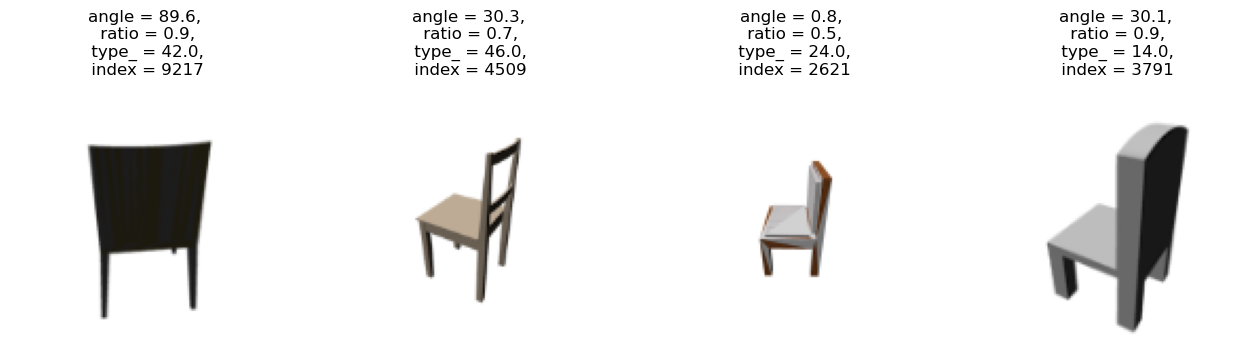

In [5]:
import matplotlib.pyplot as plt
import numpy as np

num_imgs = 4
indices = np.random.randint(len(dataset), size=4)
fig, axs = plt.subplots(1, num_imgs, figsize=(4*num_imgs, 4))
images = dataset[indices]["image"]
angles = dataset[indices]["angle"]
ratios = dataset[indices]["ratio"]
types = dataset[indices]["type"]
for i, info in enumerate(zip(images, angles, ratios, types, indices)):
    image = info[0]
    angle = info[1]
    ratio = info[2]
    type_ = info[3]
    index = info[4]
    axs[i].imshow(image)
    axs[i].set_title(f"{angle = },\n {ratio = },\n {type_ = },\n {index = }")
    axs[i].set_axis_off()
fig.show()

In [6]:
# 가져온 데이터상의 최대 각도를 산출 및 추후 학습 때 사용

angle_max = max(dataset["angle"])
print(f"{angle_max = }")

angle_max = 90.0


### Define data transforms

In [7]:
from torchvision import transforms

# image transform
preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [8]:
import torch

# image and label transform
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    labels = [[angle / angle_max if angle_max > 0 else 0.0, ratio] for angle, ratio in zip(examples["angle"], examples["ratio"])]
    labels = torch.Tensor(labels)
    return {"images": images, "labels": labels}


dataset.set_transform(transform)

In [9]:
# dataloader instanciation

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

### Load model

In [10]:
import os
import sys

# 이전에 pip uninstall diffusers 를 통해
# 기존의 diffusers 패키지 삭제함
folder = 'C:\\Users\\msi\\Desktop\\workspace\\001_현대자동차\\03_diffusion\\diffusers\\src'

if os.path.exists(folder) and folder not in sys.path:
    sys.path.append(folder)
    print(sys.path)

['C:\\Users\\msi\\anaconda3\\envs\\hf_diffusers\\python312.zip', 'C:\\Users\\msi\\anaconda3\\envs\\hf_diffusers\\DLLs', 'C:\\Users\\msi\\anaconda3\\envs\\hf_diffusers\\Lib', 'C:\\Users\\msi\\anaconda3\\envs\\hf_diffusers', '', 'C:\\Users\\msi\\anaconda3\\envs\\hf_diffusers\\Lib\\site-packages', 'C:\\Users\\msi\\anaconda3\\envs\\hf_diffusers\\Lib\\site-packages\\win32', 'C:\\Users\\msi\\anaconda3\\envs\\hf_diffusers\\Lib\\site-packages\\win32\\lib', 'C:\\Users\\msi\\anaconda3\\envs\\hf_diffusers\\Lib\\site-packages\\Pythonwin', 'C:\\Users\\msi\\Desktop\\workspace\\001_현대자동차\\03_diffusion\\diffusers\\src']


In [11]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
    class_embed_type="continuous_vector",
    num_continuous_conditions=2
)

# pretrained 모델 사용
if config.resume_epoch_from:
    print("Pretrained model exists")
    model = model.from_pretrained(config.hub_model_id, subfolder="unet", use_safetensors=True)

In [12]:
# # 추가
# model_config_dir = os.path.join(config.output_dir, "unet")
# if os.path.exists(model_config_dir) and "config.json" in os.listdir(model_config_dir):
#     print("Pretrained model exists")
#     model = model.from_pretrained(model_config_dir, use_safetensors=True)

In [13]:
sample_idx = 3
sample_image = dataset[sample_idx]["images"].unsqueeze(0)
sample_labels = dataset[sample_idx]["labels"].unsqueeze(0)

print("Input shape:", sample_image.shape)

print("Output shape:", model(sample_image, timestep=0, class_labels=sample_labels).sample.shape)

Input shape: torch.Size([1, 3, 128, 128])
Output shape: torch.Size([1, 3, 128, 128])


## Create a scheduler

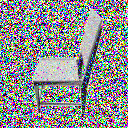

In [14]:
import torch
from PIL import Image
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

# get noise scheduler from config.json(pretrained does not affect the scheduler though)
# 추가
# scheduler_config_dir = os.path.join(config.output_dir, "scheduler")
# if os.path.exists(scheduler_config_dir) and "scheduler_config.json" in os.listdir(scheduler_config_dir): 
#     print("Scheduler config exists")
#     noise_scheduler = noise_scheduler.from_pretrained(scheduler_config_dir, use_safetensors=True)

noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [15]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps, sample_labels).sample
loss = F.mse_loss(noise_pred, noise)

## Train the model

In [16]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    # num_warmup_steps=0 if config.resume_epoch_from else config.lr_warmup_steps, # 추가
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [17]:
from diffusers import ConditionalDDPMPipeline
from diffusers.utils import make_image_grid
import os

def evaluate(config, epoch, pipeline, condition):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
        condition=condition,
    ).images

    # Make a grid out of the images
    image_grid = make_image_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [18]:
def make_condition(angle, ratio, device):
    condition = torch.Tensor([angle / angle_max if angle_max > 0 else 0.0, ratio]).to(device)
    return condition

In [19]:
from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id=config.hub_model_id or Path(config.output_dir).name, exist_ok=True
            ).repo_id
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.resume_epoch_from, config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch["images"]
            batch_labels = batch["labels"]
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device,
                dtype=torch.int64
            )

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, batch_labels, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = ConditionalDDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline, make_condition(45.0, 0.7, clean_images.device))

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    pipeline.save_pretrained(config.output_dir)
                    upload_folder(
                        repo_id=repo_id,
                        folder_path=config.output_dir,
                        commit_message=f"Epoch {epoch}",
                        ignore_patterns=["step_*", "epoch_*"],
                    )
                    print(f"{epoch} epoch model pushed")
                else:
                    pipeline.save_pretrained(config.output_dir)

In [20]:
# !pip install wandb tensorboard

In [ ]:
from accelerate import notebook_launcher

args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


  0%|          | 0/332 [00:00<?, ?it/s]

C:\Users\msi\Desktop\workspace\001_현대자동차\03_diffusion\diffusers\src\diffusers\models\attention_processor.py:1279: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  hidden_states = F.scaled_dot_product_attention(


  0%|          | 0/1000 [00:00<?, ?it/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1713248668.DESKTOP-PDH94BV.33924.0:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

0 epoch model pushed


  0%|          | 0/332 [00:00<?, ?it/s]